In [1]:
%matplotlib inline
import mdtraj as md
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors
import matplotlib.pyplot as plt
import collections as col
import matplotlib as mpl
import os
import glob
import subprocess
import pyemma.coordinates as coor
import pyemma.plots as mplt
import seaborn as sns
from adjustText import adjust_text

print(os.getcwd())


indir="../../REST2_dynamics/UUCG/300K"

/mnt/h/dimitris/RNA_simulations/mock_systems/github_code_example/conformational_analysis/notebooks


# Custom functions

In [2]:
### Function to create a custom cmap based on tab10 to be used throughout.
def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap

In [3]:
### CLUSTERING AND FREE ENERGY SURFACE FUNCTIONS

def run_dash(dihed_file, outfile, f, y):
    """Input: dihed trajectory file and f and y parameters for dash
    Output: runs dash clustering and saves output file"""
    p=subprocess.Popen(['mdash', '-i', dihed_file , '-o', outfile, '-x', '-H', '-f', str(f), '-y', str(y)],
                       stdin=subprocess.PIPE)# run dash clustering (will need to change the dash executable for your installation)
    p.wait()

def save_dihedrals(xtc, outfile, gro, atom_indexes):
    """Read in xtc and save trajectory of backbone dihedral"""
    dih = coor.featurizer(gro) # create featurizer of protein only
    dih.add_dihedrals(indexes=atom_indexes, cossin=False, deg=True) # add backbone dihedrals as feature in degrees
    dih_traj = coor.load(xtc, features=dih, stride = 1) # load xtc and featurise with dihedrals
    np.savetxt(outfile, dih_traj, '%5.2f') # save file of backbone dihedral trajectory
    
def no_clusts(dash_file):
    """Input: dash file name as string
     Output: the number of clusters"""
    with open(dash_file, "r") as f: # open dash file
        lines = f.read().splitlines() # list of lines in dash file
    i = 0 # current line to read
    n_clusts=0 # start counting clusters at 0
    while lines[i] != "[REPLICA_EXCHANGE_STATES]": # iterater through lines until this line is found
        i+=1
    i+=1
    while lines[i] != "": # iterate through lines until empty line is found
        i+=1
        n_clusts += 1 # count the number of clusters present in the file
    return n_clusts # number of clusters in dash file

def clust_rep(dash_file, clust_id):
    """Input: dash file string and cluster id
    Output: trajectory index of cluster representative"""
    with open(dash_file, "r") as f: # open dash file
        lines = f.read().splitlines() # list of lines in dash file
    i=0
    while lines[i] != "[REPLICA_EXCHANGE_STATE_DISTRIBUTION]": # find this line
        i +=1
    return int(lines[i + clust_id + 1].split()[3]) -1 # return trajectory frame index of cluster

def save_clust_reps(dash_file, xtc, ref):
    """Input: dash file string, xtc string, gro file string
    Output: cluster representative pdb files"""
    n_clusts = no_clusts(dash_file) # call function to count number of clusters in dash file
    clust_ids = []
    for clust in range(1,n_clusts+1,1): # iterate through the clusters
        rep = clust_rep(dash_file, clust) # find cluster rep using this function
        md.load_xtc(xtc,ref)[rep].save_pdb(dash_file.split("output.dat")[0] + "clust_" + str(clust) + ".pdb") # save pdb for each cluster
        clust_ids.append(rep)
    return clust_ids
        
def plot_FES_and_dash_clusts(feat_traj, feat_dash_clusts, dims, x_label, y_label, title):
    """Input: A PC featurised pyemma trajectory (shape = [frames, dimensions]), the PC featurised clusters,
              a dimension list with the 2 dimensions for the FES, x_label string, y_label string, title string.
       Output: Shows a free energy surface wrt the 2 dimensions, showing cluster centres if 
               specified."""
    mplt.plot_free_energy(feat_traj[:,dims[0]], feat_traj[:,dims[1]], kT=2.494, cbar_label="Free Energy (kJ/ mol)"); # plot FES wrt the PC dimensions given in dims
    plt.xlabel(x_label,fontsize=18)
    plt.ylabel(y_label,fontsize=18)
    cc_x = feat_dash_clusts[:,dims[0]]
    cc_y = feat_dash_clusts[:,dims[1]]
    ax = plt.scatter(cc_x, cc_y, color='black')
    # Plot the native (reference) and seed structures on PC space.
    plt.scatter(native_coords[:,dims[0]], native_coords[:,dims[1]], marker='x', lw=3, s=200, c='black', zorder=2, label="Reference")
    plt.scatter(seed1_coords[:,dims[0]], seed1_coords[:,dims[1]], marker='^', lw=3, s=200, c='grey', ec='black', alpha=0.5, zorder=2, label="NMR-seeded")
    plt.scatter(seed2_coords[:,dims[0]], seed2_coords[:,dims[1]], marker='v', lw=3, s=200, c='grey', ec='black', alpha=0.5, zorder=2, label="SimRNA-seeded")
    plt.scatter(nmr_coords[:,dims[0]], nmr_coords[:,dims[1]], marker='d', lw=3, s=100, c='black', alpha=0.5, zorder=2, label="NMR")

    for i, txt in enumerate(range(1, len(cc_x)+1)):
        plt.annotate(txt, (cc_x[i], cc_y[i]), color='white', ha='center')
    plt.legend(bbox_to_anchor=(2, 1), labelspacing=2)
    plt.title(title, fontsize=20, pad=15)
    plt.savefig(title + ".png", dpi = 600, format = "png", bbox_inches='tight')
    plt.show()
    
def clust_pca(pdb_prefix, n_clusts, feat_obj, pca_obj):
    """Input: cluster file prefix, number of clusters, pyemma dihedral feature object and pyemma pca object, 
    Output: PC values for the cluster representatives"""
    clusts = md.load([pdb_prefix + str(dc) + ".pdb" for dc in range(1, n_clusts+1,1)]) # load cluster pdbs
    clust_dih = feat_obj.transform(clusts) # transform structures with dihedral features
    clust_dih_pca = pca_obj.transform(clust_dih) # transform dihedrals with PCA object
    return clust_dih_pca # return PC values

In [4]:
### PCA FUNCTIONS

def split_and_plot(data, start_frame, dim, nsplits, leg_loc, title, xlabel):
    """Input: Trajectory of PCs (shape = [frames, PC-dimensions]), first frame to include, 
       PC dimension to plot, number of portions to split trajectoy into, legend location,
       title and xlabel
       Output: PC Histograms built from the different splits of the trajectory"""
    splits = np.split(data[start_frame:,dim],nsplits) # split data into equal portions according to nsplits
    labels = [str(i) for i in range(1, nsplits+1,1)] # label for legend
    for sec in range(len(splits)): # iterate over the trajectory splits
        plt.hist(splits[sec], bins =50, histtype="stepfilled", alpha=0.5, label=labels[sec], density=True) # create histogram of PC
        plt.legend(loc=leg_loc, fontsize=15)
        plt.xlabel(xlabel, fontsize=18)
        plt.ylabel("Probability", fontsize=18)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.title(title, fontsize=20)
    #plt.savefig("hist_" + title + "_" + str(start_frame) + "_" + xlabel + ".jpeg", dpi = 'figure', quality = 95, format = "jpg", bbox_inches='tight')
    plt.show()
    
def plot_PCs(pca_object):
    """Input: pyemma pca object
    Output: plot of PCs vs percentage variance"""
    plt.scatter(range(1, len(pca_object.cumvar)+1, 1), pca_object.cumvar) # create scatter plot
    plt.hlines(pca_object.cumvar[1],0,2, colors="red") # line to show how much variance first 2 PCs describe
    plt.vlines(2,0, pca_object.cumvar[1], colors="red")
    plt.xlabel("PC", fontsize=10)
    plt.xlim(xmin=0)
    plt.ylim(0)
    plt.xticks(range(0, len(pca_object.cumvar)+1, 5))
    plt.ylabel("% Variance", fontsize=10)
    plt.title("PC % Variance", fontsize=15)
    plt.show()

# Generate an all-FF trajectory.

In [5]:
#Concatenate all FF trajectories. Take frames 
#every 1ns (SASA autocorrelation tends to 0 at this interval).

ffs = ["amber14SB", "amber14SB_{CP}", "Chen-Garcia", "DESRES"]
runs = ["ff14", "ff14_CP", "CG", "desres"]

super_trj = md.load("%s/trajectories/traj_all_ffs-comb_ensembles.xtc"%indir, \
                    top="%s/reference_structures/UUCG-native.pdb"%indir)
single_trj = md.load("%s/trajectories/traj-ff14SB-nmr.xtc"%indir, \
                    top="%s/reference_structures/UUCG-native.pdb"%indir)
print(super_trj)
print(single_trj)

<mdtraj.Trajectory with 400008 frames, 447 atoms, 14 residues, and unitcells>
<mdtraj.Trajectory with 50001 frames, 447 atoms, 14 residues, and unitcells>


# η/θ-based analysis with PCA

In [6]:
#Find indexes of pseudodihedral angles η and θ.
C4_P_idx = [atom.index for atom in super_trj.topology.atoms if atom.name=="C4'" or atom.name=="P"]
resids = [residue for residue in super_trj.topology.residues]

pseudos_idx = []
pseudos_labs = []
for i in range(len(C4_P_idx)-3):
    pseudos_idx.append([C4_P_idx[i], C4_P_idx[i+1], C4_P_idx[i+2], C4_P_idx[i+3]])
    pseudos_labs.append('ETA %s'%(resids[i//2 + 1])) if i%2==0 else pseudos_labs.append('THETA %s'%(resids[i//2 + 1]))
print(pseudos_idx)
print(pseudos_labs)

[[5, 32, 39, 66], [32, 39, 66, 73], [39, 66, 73, 97], [66, 73, 97, 104], [73, 97, 104, 130], [97, 104, 130, 137], [104, 130, 137, 161], [130, 137, 161, 168], [137, 161, 168, 191], [161, 168, 191, 198], [168, 191, 198, 221], [191, 198, 221, 228], [198, 221, 228, 252], [221, 228, 252, 259], [228, 252, 259, 286], [252, 259, 286, 293], [259, 286, 293, 320], [286, 293, 320, 327], [293, 320, 327, 350], [320, 327, 350, 357], [327, 350, 357, 384], [350, 357, 384, 391], [357, 384, 391, 415], [384, 391, 415, 422]]
['ETA G2', 'THETA G2', 'ETA C3', 'THETA C3', 'ETA A4', 'THETA A4', 'ETA C5', 'THETA C5', 'ETA U6', 'THETA U6', 'ETA U7', 'THETA U7', 'ETA C8', 'THETA C8', 'ETA G9', 'THETA G9', 'ETA G10', 'THETA G10', 'ETA U11', 'THETA U11', 'ETA G12', 'THETA G12', 'ETA C13', 'THETA C13']


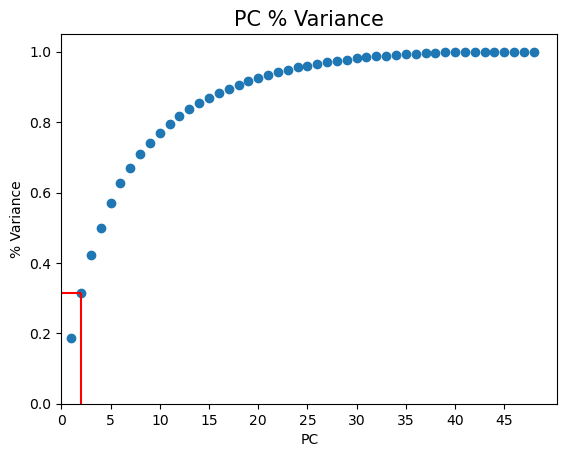

(1, 18)
(1, 18)
(1, 18)


/home/dista/anaconda3/envs/py37/lib/python3.7/site-packages/mdtraj/formats/pdb/pdbfile.py:202: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


(20, 18)


In [7]:
### PCA MAIN CODE

# This section uses pyemma to featurise the trajectory (i.e describe the trajectory as backbone dihedral angles),
# followed by PCA on the dihedral trajectory to create a PC trajectory
# it then plots the percentage variance described by the PCs
# and the plots histograms of the PCs

gro = "%s/reference_structures/UUCG-native.pdb"%indir
xtc = "%s/trajectories/traj_all_ffs-comb_ensembles.xtc"%indir

# Change output trajectory
outdir="../output/UUCG/300K/pseudodihedral_PCA"
os.system("mkdir -p %s"%outdir)

# Get all-FF traj coordinates in PC space.
dih_cos = coor.featurizer(gro) #create pyemma featurizer from protein only gro
dih_cos.add_dihedrals(indexes=pseudos_idx, cossin=True, periodic=False, deg=True) #add backbone dihedrals as features
dih_cos_traj = coor.load(xtc, features=dih_cos, stride = 1) #load trajectory and describe as dihedrals
dih_pca = coor.pca(dih_cos_traj, var_cutoff=0.9) #perform PCA on dihedral traj
dih_pca_traj = dih_pca.get_output()[0] #traj of PCs
plot_PCs(dih_pca) #use function to plot PC variance

# Get native and seed states coordinates in PC space.
native = md.load("%s/reference_structures/UUCG-native.pdb"%indir)
native.save("%s/UUCG-native.xtc"%outdir)
dih_cos_nat = coor.load("%s/UUCG-native.xtc"%outdir, features=dih_cos, stride=1) #load trajectory and describe as dihedrals
native_coords = dih_pca.transform(dih_cos_nat)
print(native_coords.shape)

seed1 = md.load("%s/reference_structures/UUCG-nmr.pdb"%indir)
seed1.save("%s/UUCG-nmr.xtc"%outdir)
dih_cos_sd1 = coor.load("%s/UUCG-nmr.xtc"%outdir, features=dih_cos, stride=1) #load trajectory and describe as dihedrals
seed1_coords = dih_pca.transform(dih_cos_sd1)
print(seed1_coords.shape)

seed2 = md.load("%s/reference_structures/UUCG-simrna.pdb"%indir)
seed2.save("%s/UUCG-simrna.xtc"%outdir)
dih_cos_sd2 = coor.load("%s/UUCG-simrna.xtc"%outdir, features=dih_cos, stride=1) #load trajectory and describe as dihedrals
seed2_coords = dih_pca.transform(dih_cos_sd2)
print(seed2_coords.shape)

# Get PDB ensemble coordinates in PC space
nmr = md.load("%s/reference_structures/2KOC.pdb"%indir, atom_indices=range(3, native.n_atoms+3)) #cut out residue 1 phosphate atoms.
nmr.save("%s/2KOC.xtc"%outdir)
dih_cos_nmr = coor.load("%s/2KOC.xtc"%outdir, features=dih_cos, stride=1) #load trajectory and describe as dihedrals
nmr_coords = dih_pca.transform(dih_cos_nmr)
print(nmr_coords.shape)

np.savetxt("%s/traj_all_ffs-rna-pseudodihedral_PCA.proj"%outdir, dih_pca_traj) #save the PC-space coordinates

## Distribution characteristics.

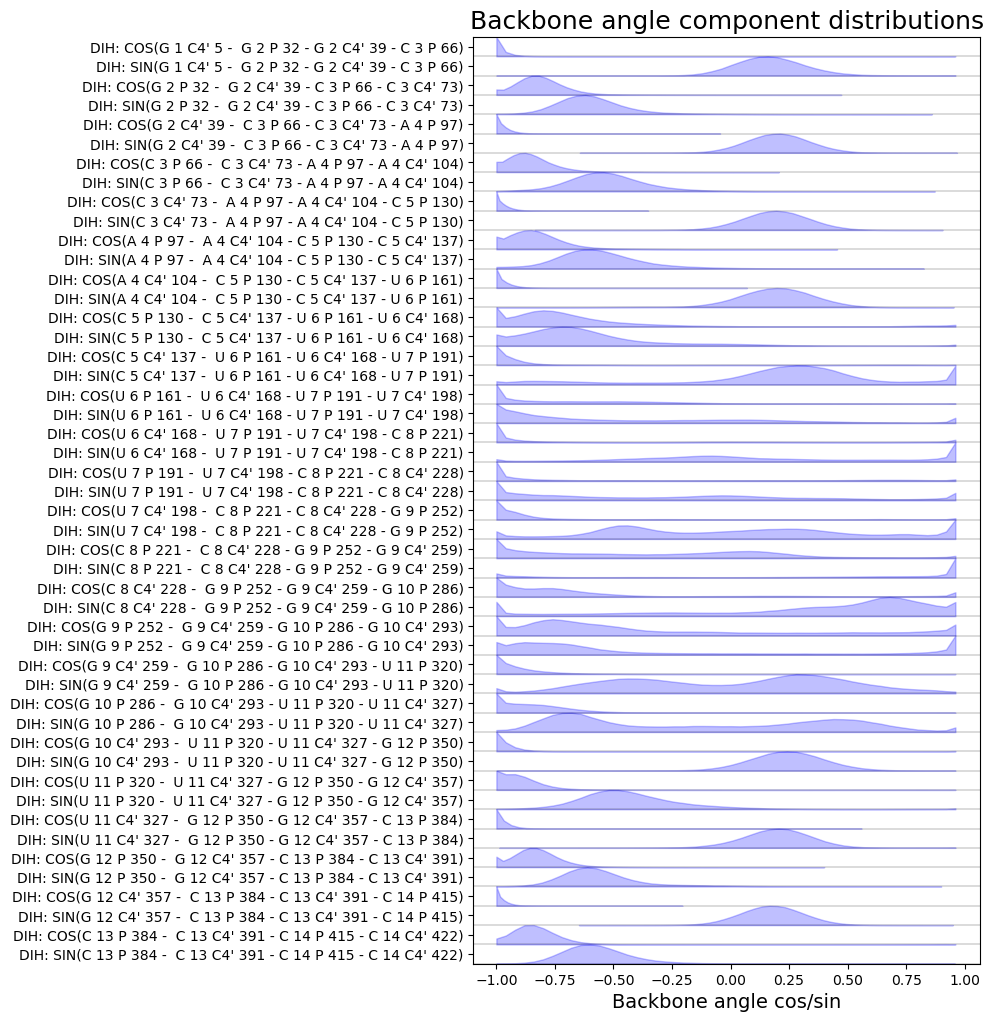

In [8]:
# Plot feature coordinate distributions.
fig, ax = plt.subplots(figsize=(10, 10))
mplt.plot_feature_histograms(dih_cos_traj, feature_labels=dih_cos, ax=ax, ignore_dim_warning=True)
fig.tight_layout()
ax.set_title("Backbone angle component distributions", fontsize=18)
ax.set_xlabel("Backbone angle cos/sin", fontsize=14)

plt.show()

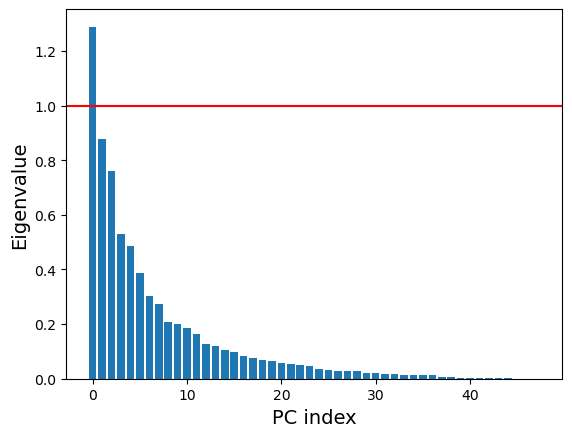

In [9]:
# Show most important PCs. 
plt.bar(x=range(len(dih_pca.eigenvalues)), height=dih_pca.eigenvalues)
plt.axhline(y=1, c='red') #PCs with eigenvalues >=1 are considered the most useful.
plt.xlabel("PC index", fontsize=14)
plt.ylabel("Eigenvalue", fontsize=14)
plt.show()

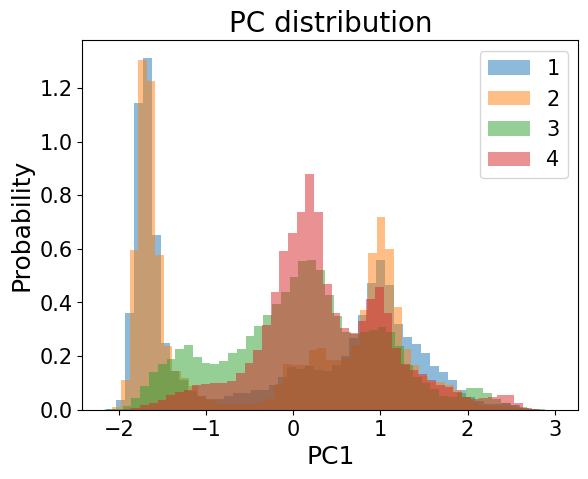

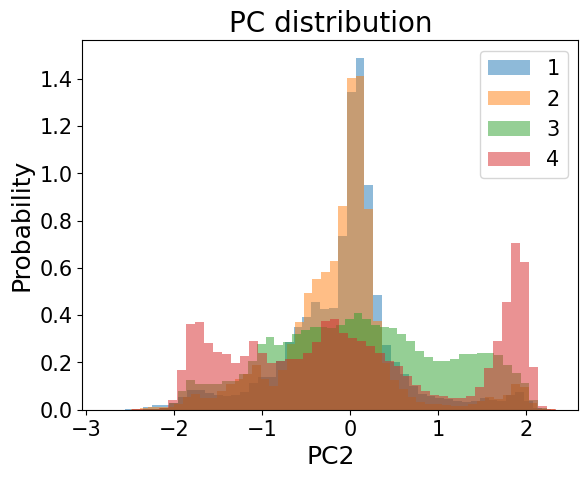

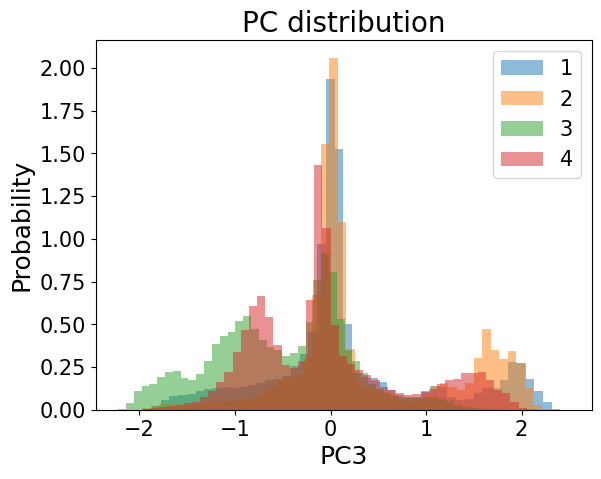

In [10]:
# Plot PC coordinate distribution histograms.
for i in range(3): # iterate through first 3 PCs.
    split_and_plot(dih_pca_traj,len(dih_pca_traj)%len(ffs),i, len(ffs), "best", "PC distribution", "PC"+str(i+1))# plot PC histogram

In [11]:
# Score the quality of the PCA features!
#The minimum value of this score is 1, which corresponds to the invariant measure or the observed equilibrium.
#e.g. the score of 1.5 means that we have the constant of 1 plus a total contribution of 0.5 from the other dynamic processes.

score_phi_psi = coor.vamp(dih_cos_traj[len(dih_cos_traj)//2:], dim=2).score(test_data=dih_cos_traj[:len(dih_cos_traj)//2], score_method='VAMP2')
print('VAMP2-score backbone torsions: {:.2f}'.format(score_phi_psi))
score_phi_psi = coor.vamp(dih_cos_traj[:len(dih_cos_traj)//2], dim=2).score(test_data=dih_cos_traj[len(dih_cos_traj)//2:], score_method='VAMP2')
print('VAMP2-score backbone torsions: {:.2f}'.format(score_phi_psi))

VAMP2-score backbone torsions: 1.26
VAMP2-score backbone torsions: 1.18


(48, 48)


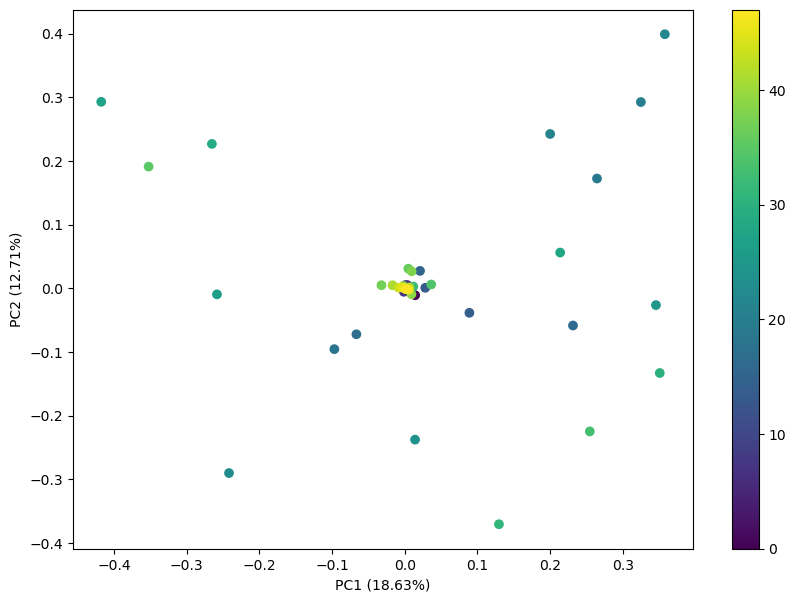

In [12]:
# Plot the loadings of the first 2 features on (first) two PCs. (see https://towardsdatascience.com/principal-component-analysis-3c39fbf5cb9d for reference).
#(Qualitatively the same as above)
loadings = np.sqrt(dih_pca.eigenvalues)*dih_pca.eigenvectors
loadings_sq = loadings**2
print(loadings.shape)
plt.figure(figsize=(10, 7))
plt.scatter(loadings[:,0],loadings[:,1], \
            c=range(dih_cos.active_features[0].dimension), cmap="viridis")
plt.colorbar()
plt.xlabel("PC1 (%.2f"%(dih_pca.cumvar[0]*100)+"%)")
plt.ylabel("PC2 (%.2f"%((dih_pca.cumvar[1] - dih_pca.cumvar[0])*100)+"%)")
plt.show()

In [13]:
# Get a list of the feature names.
features = []
for dih in pseudos_labs:
    features.append("COS(%s)"%dih)
    features.append("SIN(%s)"%dih)

features = np.array(features)
print(features.shape)

(48,)


[]

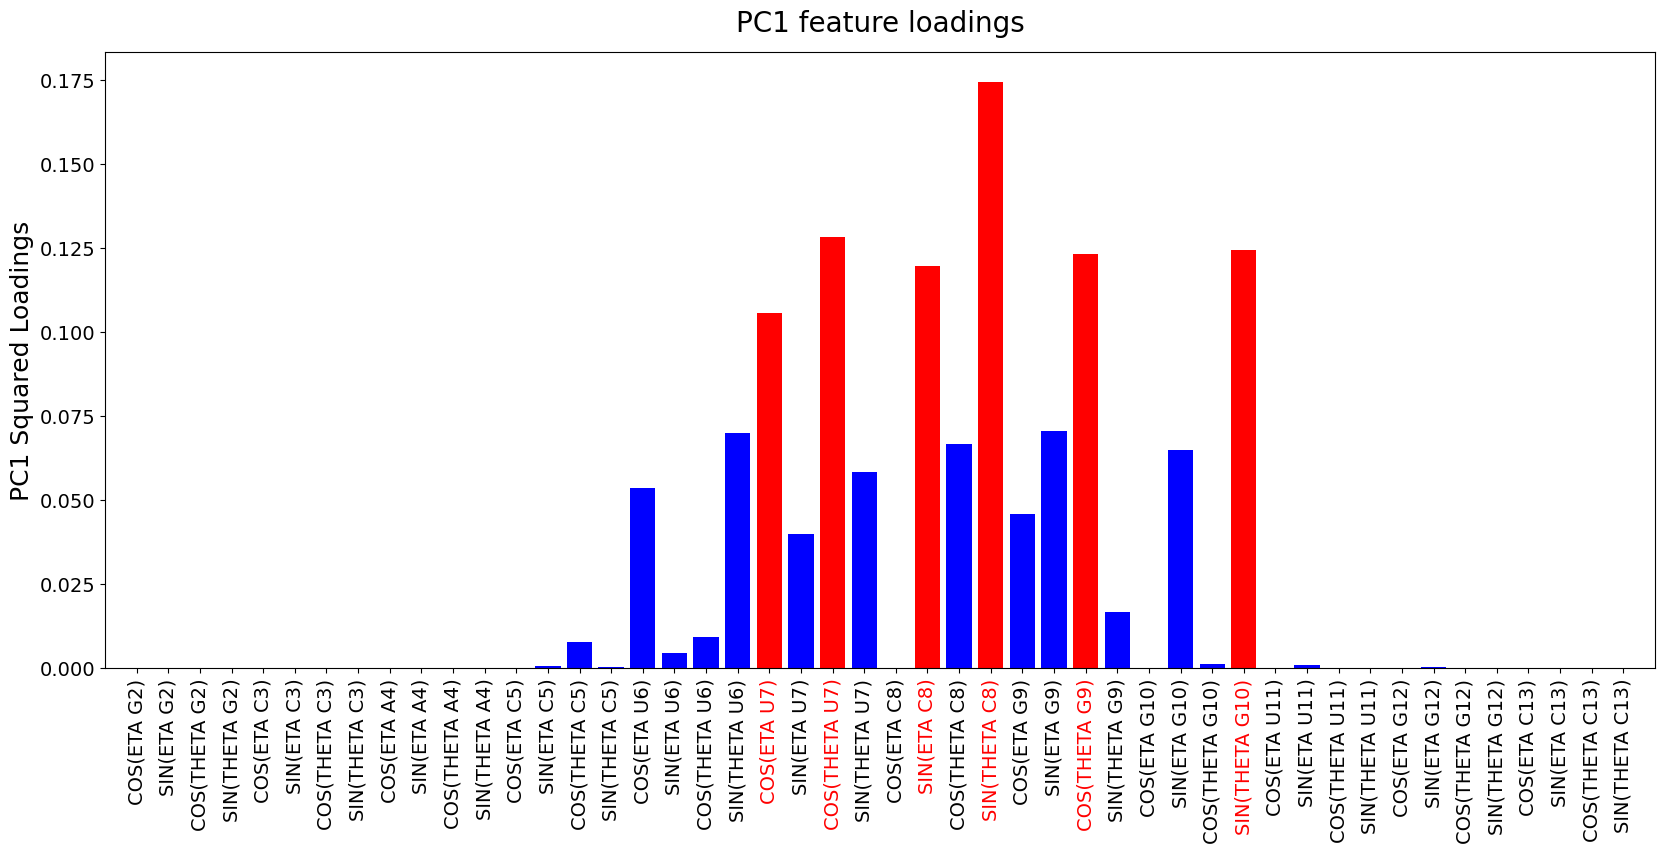

In [14]:
# Plot PC1 feature loadings.
colors = ['blue']*len(loadings_sq)
for i in range(len(loadings_sq)):
    if loadings_sq[i, 0] >= 0.1:
        colors[i]='red'

        
plt.figure(figsize=(20, 8))
plt.bar(x=range(len(dih_pca.eigenvalues)), height=loadings_sq[:,0], tick_label=features, color=colors)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0-1, len(dih_pca.eigenvalues))
#change the color of high-loading feature x-ticks.
for i, c in enumerate(colors):
    if c=='red':
        plt.gca().get_xticklabels()[i].set_color("red")

plt.ylabel("PC1 Squared Loadings",fontsize=18)
plt.title("PC1 feature loadings", fontsize=20, pad=15)
# plt.savefig("%s/PC_features-vs-PC1_loadings"%outdir + ".png", dpi = 600, format = "png", bbox_inches='tight')

plt.plot()

[]

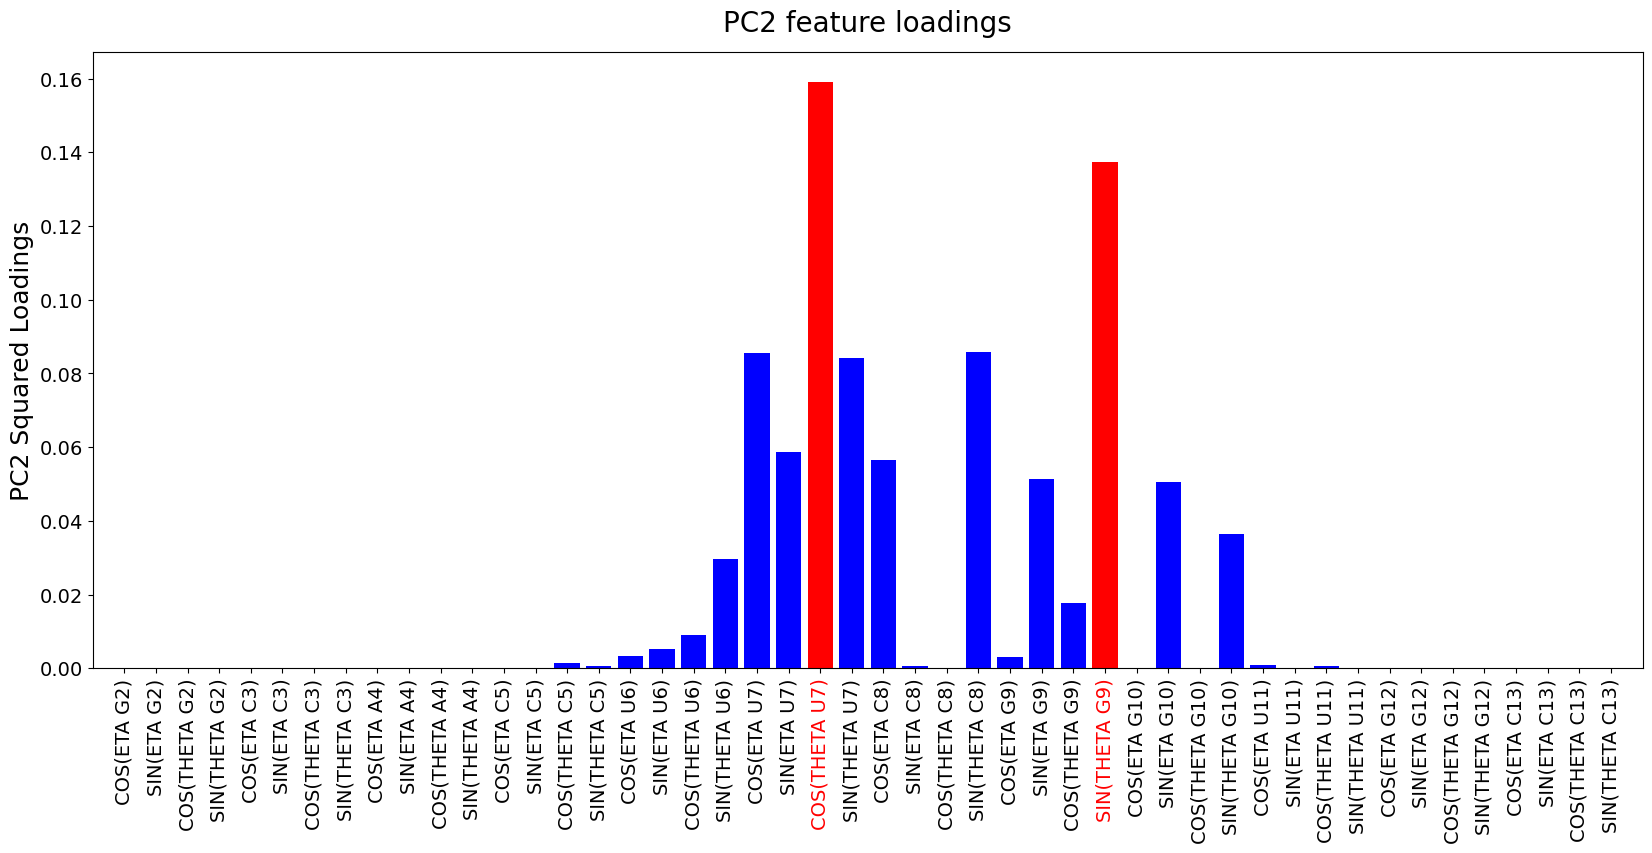

In [15]:
# Plot PC2 feature loadings.
colors = ['blue']*len(loadings_sq)
for i in range(len(loadings_sq)):
    if loadings_sq[i, 1] >= 0.1:
        colors[i]='red'

        
plt.figure(figsize=(20, 8))
plt.bar(x=range(len(dih_pca.eigenvalues)), height=loadings_sq[:,1], tick_label=features, color=colors)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0-1, len(dih_pca.eigenvalues))
#change the color of high-loading feature x-ticks.
for i, c in enumerate(colors):
    if c=='red':
        plt.gca().get_xticklabels()[i].set_color("red")

plt.ylabel("PC2 Squared Loadings",fontsize=18)
plt.title("PC2 feature loadings", fontsize=20, pad=15)
# plt.savefig("%s/PC_features-vs-PC2_loadings"%outdir + ".png", dpi = 600, format = "png", bbox_inches='tight')

plt.plot()

[]

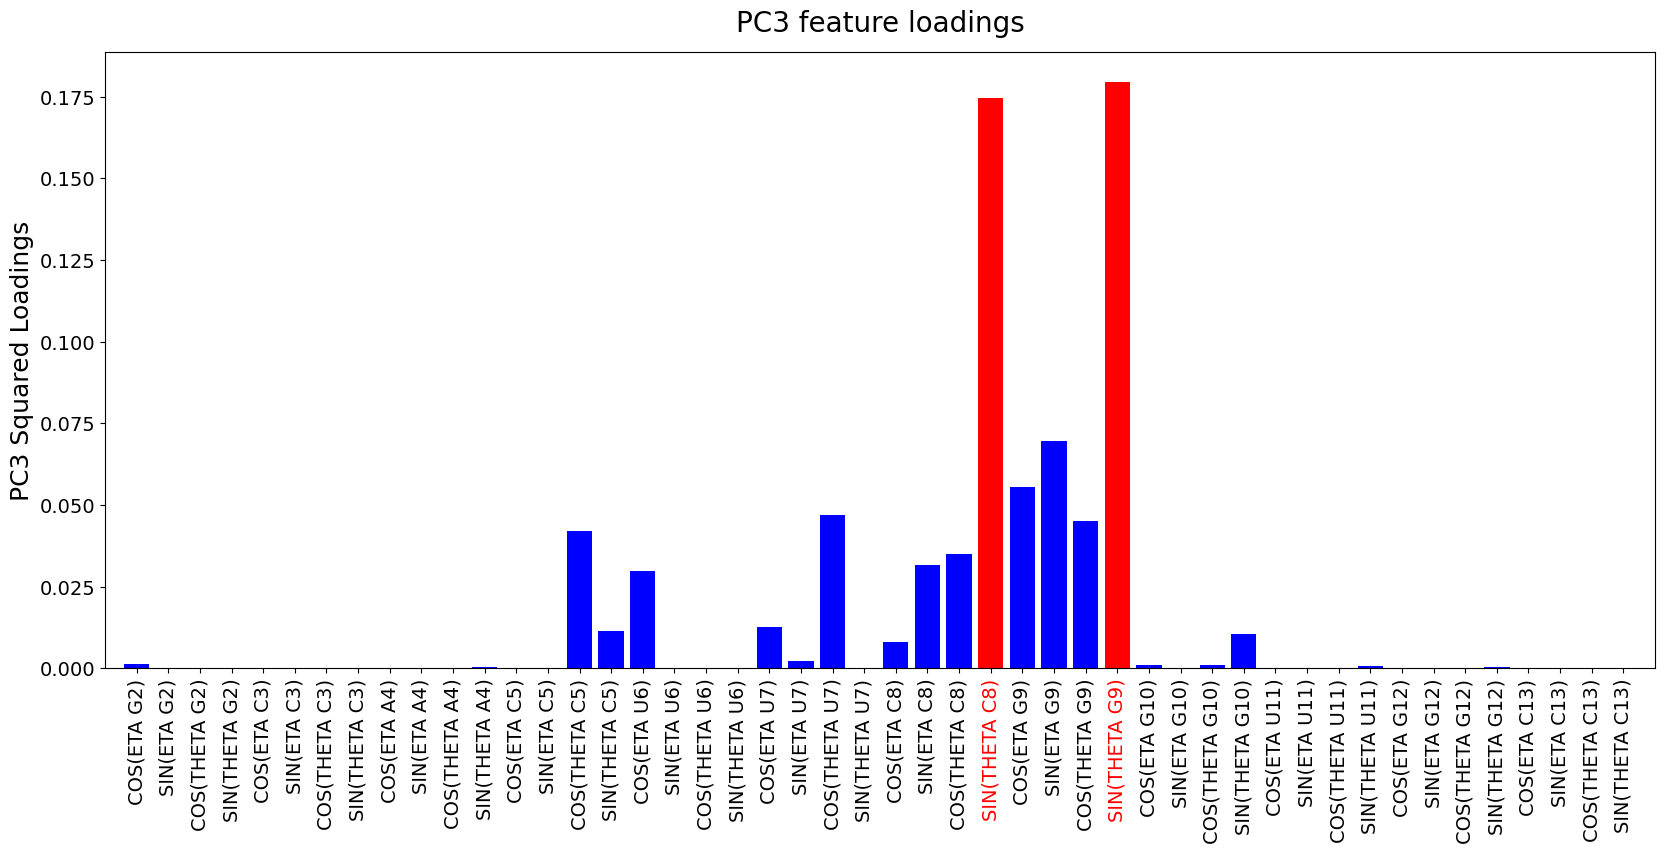

In [16]:
# Plot PC3 feature loadings.
colors = ['blue']*len(loadings_sq)
for i in range(len(loadings_sq)):
    if loadings_sq[i, 2] >= 0.1:
        colors[i]='red'

        
plt.figure(figsize=(20, 8))
plt.bar(x=range(len(dih_pca.eigenvalues)), height=loadings_sq[:,2], tick_label=features, color=colors)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0-1, len(dih_pca.eigenvalues))
#change the color of high-loading feature x-ticks.
for i, c in enumerate(colors):
    if c=='red':
        plt.gca().get_xticklabels()[i].set_color("red")

plt.ylabel("PC3 Squared Loadings",fontsize=18)
plt.title("PC3 feature loadings", fontsize=20, pad=15)
# plt.savefig("%s/PC_features-vs-PC3_loadings"%outdir + ".png", dpi = 600, format = "png", bbox_inches='tight')

plt.plot()

# FES and DASH clustering

Reading trajectory file /mnt/h/dimitris/RNA_simulations/mock_systems/github_code_example/conformational_analysis/notebooks/../output/UUCG/300K/pseudodihedral_PCA/diheds.dat ...
Found 24 variables, 400008 frames
Calculating states ...
Calculation completed successfully in 4.0s


[-0.76963069 -1.67934055  0.95957172  0.10020357]
[-0.17629763  0.02933686  0.48679017  1.46471723]


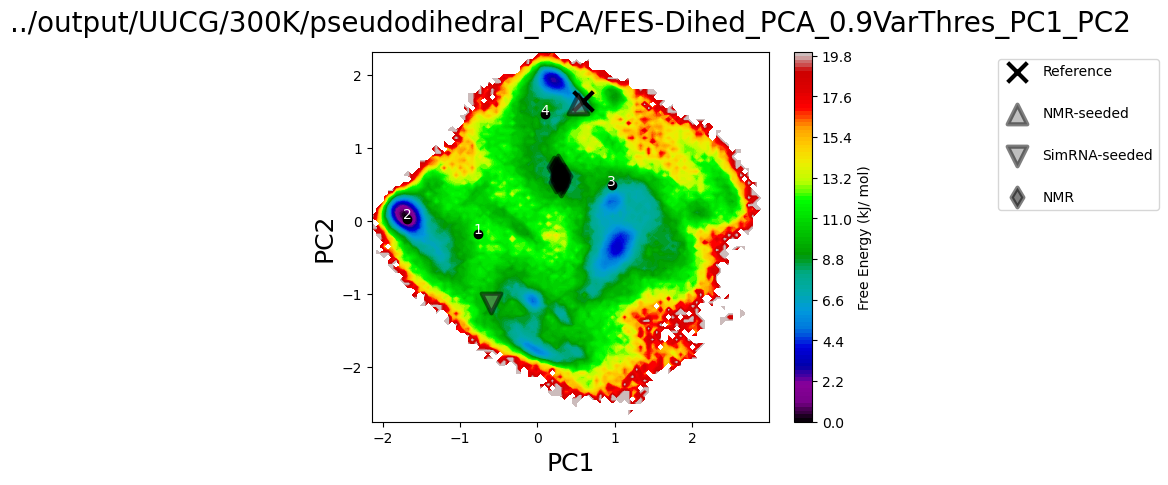

In [17]:
### FES AND DASH CLUSTERING MAIN CODE

# This section saves the dihedral trajectory as a .dat file, then performs dash clustering on the file,
# then it saves the dash cluster representatives as pdb structures,
# then it reads the cluster pdbs and transforms them into PC coordinates
# then it plots the FES wrt PC space and plots the dash clusters on the top

save_dihedrals(xtc, "%s/diheds.dat"%outdir, gro, atom_indexes=pseudos_idx) # save dihedral trajectory
run_dash("%s/diheds.dat"%outdir, "%s/dash_output.dat"%outdir, 2.4, 0.01) # run dash
cluster_ids = save_clust_reps("%s/dash_output.dat"%outdir, xtc ,gro) #save cluster representatives
nclusts = no_clusts("%s/dash_output.dat"%outdir) # number of clusters
cluster_pca = clust_pca("%s/dash_clust_"%outdir, nclusts, dih_cos, dih_pca) # PC values for clusters

# Plot FES on PC1-PC2 space.
print (cluster_pca[:,0]) # print PC1 for each cluster
print (cluster_pca[:,1]) # print PC2 for each cluster
plot_FES_and_dash_clusts(dih_pca_traj, cluster_pca , [0,1], "PC1", "PC2", "%s/FES-Dihed_PCA_0.9VarThres_PC1_PC2"%outdir) # plot FES and dash clusters

[-0.76963069 -1.67934055  0.95957172  0.10020357]
[ 0.31500429 -0.01064825  1.00336433 -0.1570973 ]


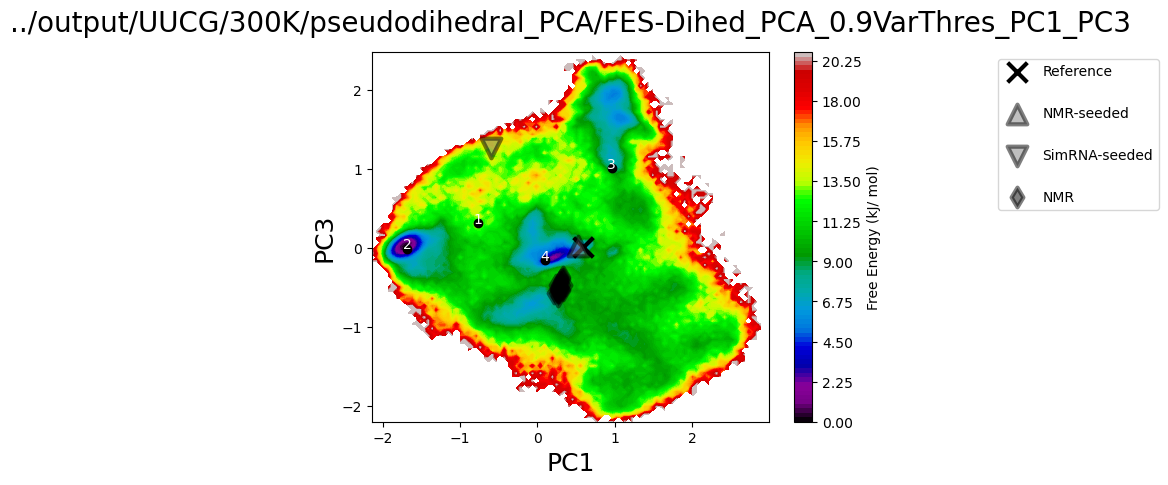

In [18]:
# Plot FES on PC1-PC3 space.
print (cluster_pca[:,0]) # print PC1 for each cluster
print (cluster_pca[:,2]) # print PC2 for each cluster
plot_FES_and_dash_clusts(dih_pca_traj, cluster_pca , [0,2], "PC1", "PC3", "%s/FES-Dihed_PCA_0.9VarThres_PC1_PC3"%outdir) # plot FES and dash clusters

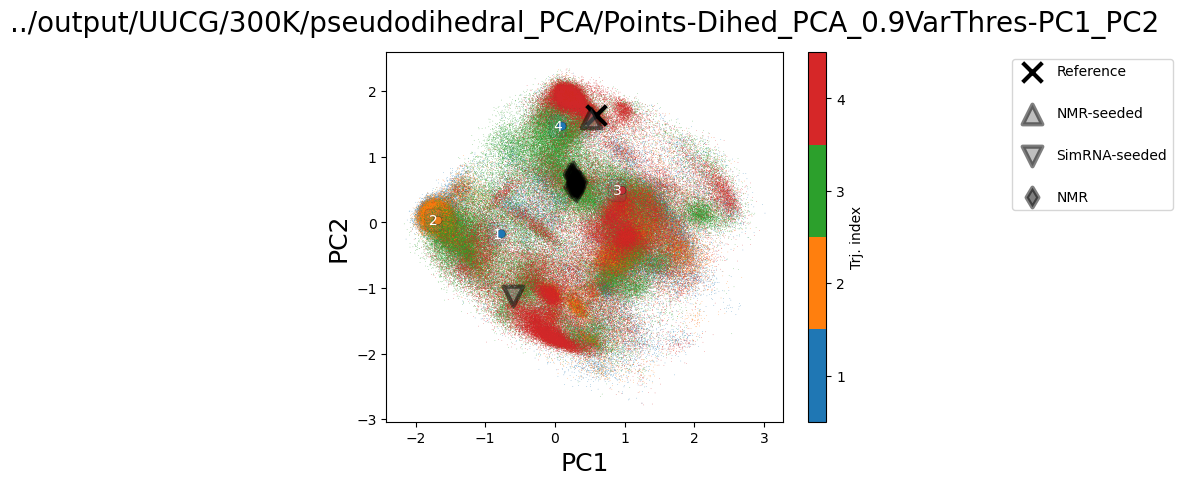

In [19]:
# Same PC1-PC2 map with color-coded trajectory points (using a variation of plot_FES_and_dash_clusts).

def plot_FES_and_dash_clusts(feat_traj, feat_dash_clusts, dims, fr_per_trj, x_label, y_label, title):
    """Input: A PC featurised pyemma trajectory (shape = [frames, dimensions]), the PC featurised clusters,
              a dimension list with the 2 dimensions for the FES, x_label string, y_label string, title string.
       Output: Shows a free energy surface wrt the 2 dimensions, showing cluster centres if 
               specified."""

    #Make a colorspace and trj-based color indexes.
    cindexes = np.arange(dih_pca_traj.shape[0]) // (fr_per_trj+1)
    #first value defines num. of color catgories, second num. of hue categories, third the cmap to choose from.   
    cat_cmap = categorical_cmap(len(ffs), 1, "tab10")   
    #color points based on trj. Runs under same ff are colored in different hues.
    colors = cat_cmap(cindexes)

    sc=plt.scatter(feat_traj[:,dims[0]], feat_traj[:,dims[1]], alpha=0.8, color=colors, \
                   vmin=0, vmax=(cindexes[-1]+1), lw=0.1, s=0.1, cmap=cat_cmap)

    norm = mpl.colors.Normalize(vmin=cindexes[0]+0.5, vmax=cindexes[-1]+1+0.5)
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cat_cmap), ticks=range(cindexes[-1]+2), label='Trj. index')

    #Plot the rest of the plot.
    plt.xlabel(x_label,fontsize=18)
    plt.ylabel(y_label,fontsize=18)
    cc_x = feat_dash_clusts[:,dims[0]]
    cc_y = feat_dash_clusts[:,dims[1]]
    plt.scatter(cc_x,cc_y,color=colors[cluster_ids], edgecolors='black', lw=0.2)

    # Plot the native (reference) and seed structures on PC space.
    plt.scatter(native_coords[:,dims[0]], native_coords[:,dims[1]], marker='x', lw=3, s=200, c='black', zorder=2, label="Reference")
    plt.scatter(seed1_coords[:,dims[0]], seed1_coords[:,dims[1]], marker='^', lw=3, s=200, c='grey', ec='black', alpha=0.5, zorder=2, label="NMR-seeded")
    plt.scatter(seed2_coords[:,dims[0]], seed2_coords[:,dims[1]], marker='v', lw=3, s=200, c='grey', ec='black', alpha=0.5, zorder=2, label="SimRNA-seeded")
    plt.scatter(nmr_coords[:,dims[0]], nmr_coords[:,dims[1]], marker='d', lw=3, s=100, c='black', alpha=0.5, zorder=2, label="NMR")

    for i, txt in enumerate(range(1, len(cc_x)+1)):
        plt.annotate(txt, (cc_x[i], cc_y[i]), color='white', ha='right', va='center', \
                     bbox=dict(boxstyle="round", alpha=0.1), size=10)
    plt.title(title, fontsize=20, pad=15)
    plt.legend(bbox_to_anchor=(2, 1), labelspacing=2)
    
    plt.savefig(title + ".png", dpi = 600, format = "png", bbox_inches='tight')
    plt.show()

#####################################

# each FF trajectory has length 2*len(single_trj)
plot_FES_and_dash_clusts(dih_pca_traj, cluster_pca , [0,1], 2*len(single_trj), \
                         "PC1", "PC2", "%s/Points-Dihed_PCA_0.9VarThres-PC1_PC2"%outdir) # plot FES and dash clusters

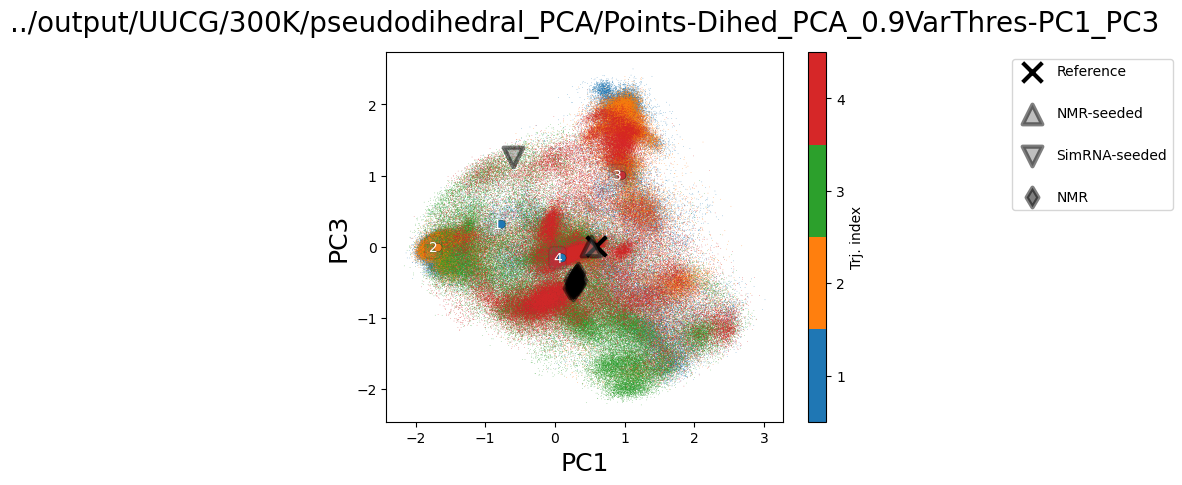

In [20]:
#PC1-PC3 map.
plot_FES_and_dash_clusts(dih_pca_traj, cluster_pca , [0,2], 2*len(single_trj), \
                         "PC1", "PC3", "%s/Points-Dihed_PCA_0.9VarThres-PC1_PC3"%outdir) # plot FES and dash clusters
# plt.close()

Reading trajectory file /mnt/h/dimitris/RNA_simulations/mock_systems/github_code_example/conformational_analysis/notebooks/../output/UUCG/300K/pseudodihedral_PCA/diheds_ff14.dat ...
Found 24 variables, 100002 frames
Calculating states ...
Calculation completed successfully in 1.0s


(4, 18)


Reading trajectory file /mnt/h/dimitris/RNA_simulations/mock_systems/github_code_example/conformational_analysis/notebooks/../output/UUCG/300K/pseudodihedral_PCA/diheds_ff14_CP.dat ...
Found 24 variables, 100002 frames
Calculating states ...
Calculation completed successfully in 1.0s


(11, 18)


Reading trajectory file /mnt/h/dimitris/RNA_simulations/mock_systems/github_code_example/conformational_analysis/notebooks/../output/UUCG/300K/pseudodihedral_PCA/diheds_CG.dat ...
Found 24 variables, 100002 frames
Calculating states ...
Calculation completed successfully in 1.0s


(13, 18)


Reading trajectory file /mnt/h/dimitris/RNA_simulations/mock_systems/github_code_example/conformational_analysis/notebooks/../output/UUCG/300K/pseudodihedral_PCA/diheds_desres.dat ...
Found 24 variables, 100002 frames
Calculating states ...
Calculation completed successfully in 3.0s


(33, 18)
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


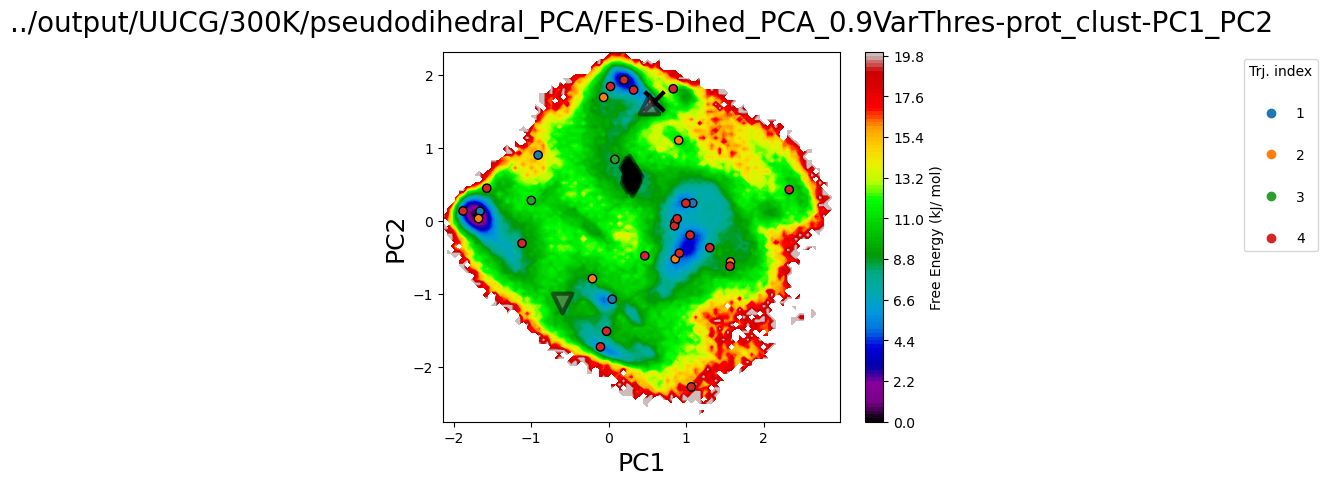

In [21]:
# Plot the centroids of individual trajectory clusters on the super-trajectory space (using a variation of plot_FES_and_dash_clusts).

def plot_FES_and_dash_clusts(feat_traj, feat_dash_clusts, dims, x_label, y_label, leg_labels, color_idxs, title):
    """Input: A PC featurised pyemma trajectory (shape = [frames, dimensions]), the PC featurised clusters,
              a dimension list with the 2 dimensions for the FES, x_label string, y_label string, title string.
       Output: Shows a free energy surface wrt the 2 dimensions, showing cluster centres if 
               specified."""
    mplt.plot_free_energy(feat_traj[:,dims[0]], feat_traj[:,dims[1]], kT=2.494, cbar_label="Free Energy (kJ/ mol)"); # plot FES wrt the PC dimensions given in dims

    #first value defines num. of color catgories, second num. of hue categories, third the cmap to choose from.   
    cat_cmap = categorical_cmap(len(ffs), 1, "tab10")   
    #color points based on trj. Runs under same ff are colored in different hues.
    colors = cat_cmap(color_idxs)

    plt.xlabel(x_label,fontsize=18)
    plt.ylabel(y_label,fontsize=18)
    cc_x = feat_dash_clusts[:,dims[0]]
    cc_y = feat_dash_clusts[:,dims[1]]

    scatter = plt.scatter(cc_x, cc_y, c=color_idxs, edgecolors='black', cmap=cat_cmap, \
                          vmin=color_idxs[0], vmax=color_idxs[-1])
   
    # Plot the native (reference) and seed structures on PC space.
    plt.scatter(native_coords[:,dims[0]], native_coords[:,dims[1]], marker='x', lw=3, s=200, c='black', zorder=2, label="Model1")
    plt.scatter(seed1_coords[:,dims[0]], seed1_coords[:,dims[1]], marker='^', lw=3, s=200, c='grey', ec='black', alpha=0.5, zorder=2, label="NMR-seeded")
    plt.scatter(seed2_coords[:,dims[0]], seed2_coords[:,dims[1]], marker='v', lw=3, s=200, c='grey', ec='black', alpha=0.5, zorder=2, label="SimRNA-seeded")
    plt.scatter(nmr_coords[:,dims[0]], nmr_coords[:,dims[1]], marker='d', lw=3, s=100, c='black', alpha=0.5, zorder=2, label="NMR")

    plt.legend(handles=scatter.legend_elements(prop="colors", num=int(color_idxs[-1]))[0], labels=[i for i in range(1,color_idxs[-1]+2)], \
               loc="upper left", title="Trj. index", bbox_to_anchor=(2, 1), labelspacing=2)

    plt.title(title, fontsize=20, pad=15)
    plt.savefig(title + ".png", dpi = 600, format = "png", bbox_inches='tight')
    plt.show()

##############################
    
    
# This section saves the dihedral trajectory as a .dat file, then performs dash clustering on the file,
# then it saves the dash cluster representatives as pdb structures,
# then it reads the cluster pdbs and transforms them into PC coordinates
# then it plots the FES wrt PC space and plots the dash clusters on the top

counter=0

for r, run in enumerate(runs):

    super_trj[r*2*len(single_trj):(r+1)*2*len(single_trj)].save("%s/../traj_%s-rna.xtc"%(outdir, run))
    xtc = "%s/../traj_%s-rna.xtc"%(outdir, run)

    save_dihedrals(xtc, "%s/diheds_%s.dat"%(outdir, run), gro, atom_indexes=pseudos_idx) # save dihedral trajectory
    run_dash("%s/diheds_%s.dat"%(outdir, run), "%s/dash_%s_output.dat"%(outdir, run), 2.4, 0.01) # run dash
    cluster_ids = save_clust_reps("%s/dash_%s_output.dat"%(outdir, run), xtc ,gro) #save cluster representatives
    nclusts = no_clusts("%s/dash_%s_output.dat"%(outdir, run)) # number of clusters
    if counter==0:
        cluster_pca = clust_pca("%s/dash_%s_clust_"%(outdir, run), nclusts, dih_cos, dih_pca) # PC values for clusters
        color_idxs = [counter for i in range(len(cluster_pca))]
    else:
        temp_cluster_pca = clust_pca("%s/dash_%s_clust_"%(outdir, run), nclusts, dih_cos, dih_pca) # PC values for clusters
        cluster_pca = np.append(cluster_pca, temp_cluster_pca, axis=0)
        color_idxs.extend([counter for i in range(len(temp_cluster_pca))])
    print(cluster_pca.shape)

    counter+=1

print(color_idxs)
plot_FES_and_dash_clusts(dih_pca_traj, cluster_pca , [0,1], "PC1", "PC2", runs, color_idxs, "%s/FES-Dihed_PCA_0.9VarThres-prot_clust-PC1_PC2"%outdir) # plot FES and dash clusters

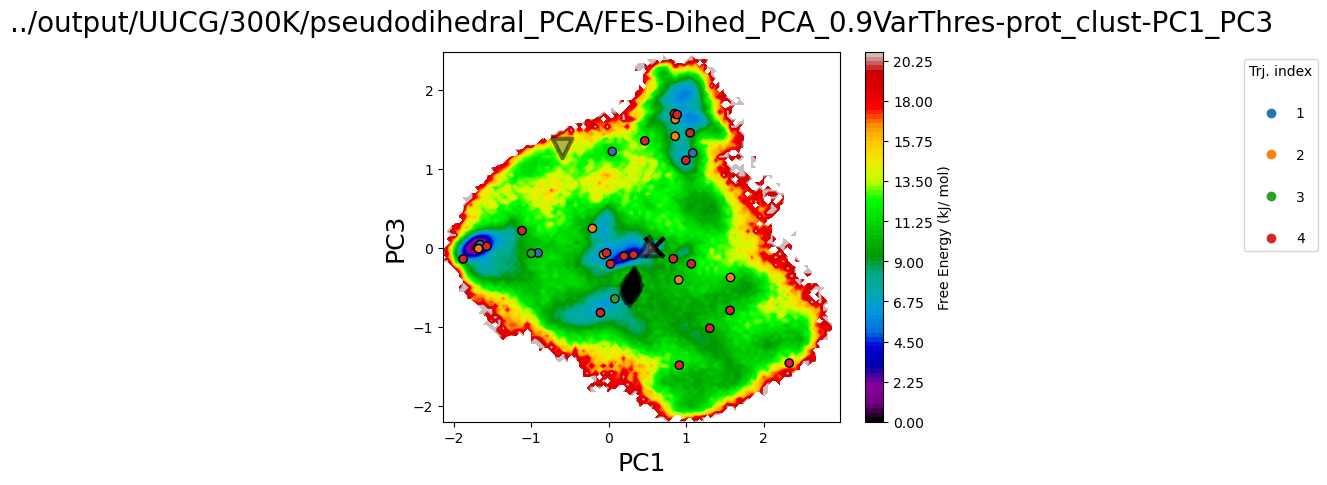

In [22]:
#do the same for PC1-PC3 space.
plot_FES_and_dash_clusts(dih_pca_traj, cluster_pca , [0,2], "PC1", "PC3", runs, color_idxs, "%s/FES-Dihed_PCA_0.9VarThres-prot_clust-PC1_PC3"%outdir) # plot FES and dash clusters

(4, 18)
(11, 18)
(13, 18)
(33, 18)


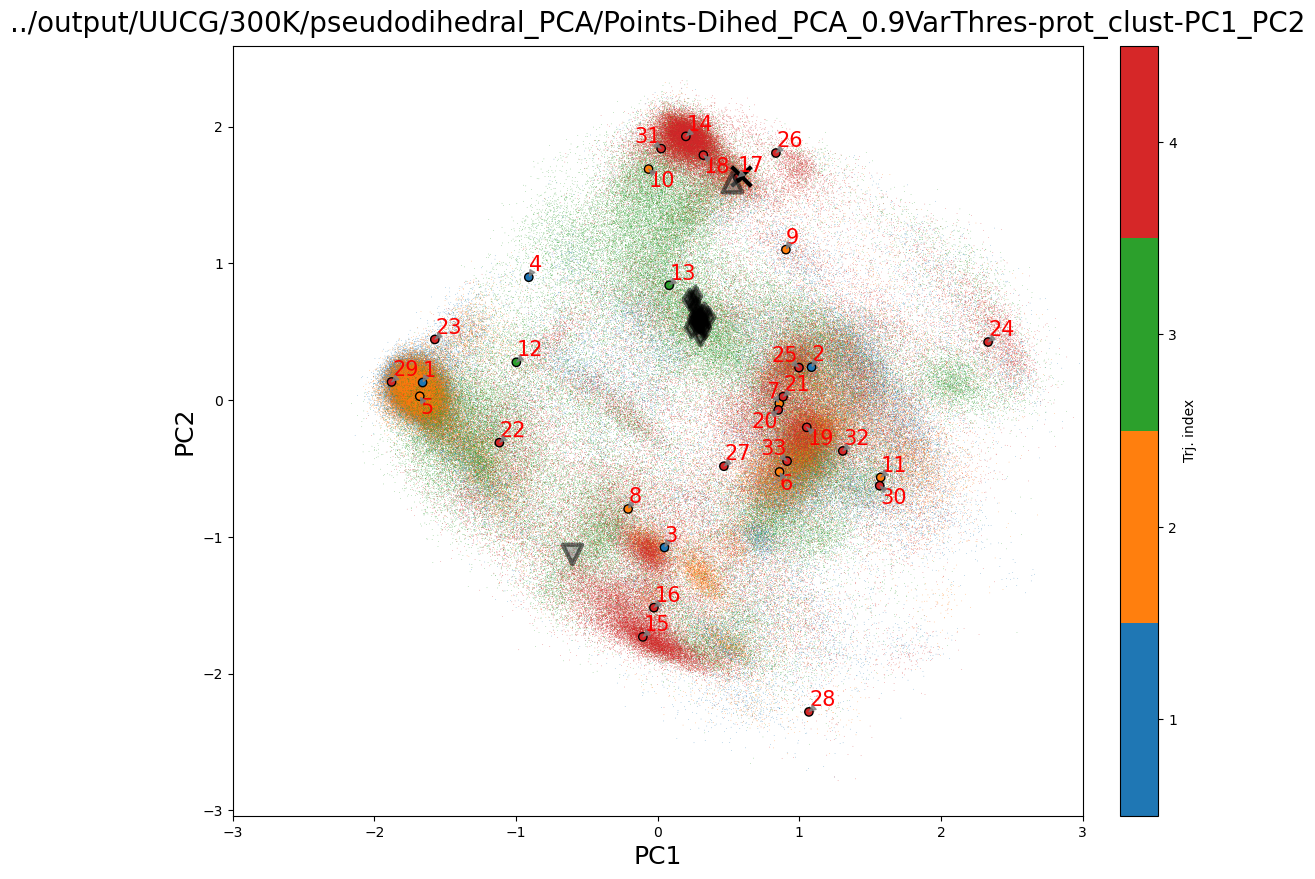

In [23]:
# Plot the same map as above, but with annotated centroids (using a variation of plot_FES_and_dash_clusts).

def plot_FES_and_dash_clusts(feat_traj, feat_dash_clusts, dims, fr_per_trj, x_label, y_label, title):
    """Input: A PC featurised pyemma trajectory (shape = [frames, dimensions]), the PC featurised clusters,
              a dimension list with the 2 dimensions for the FES, x_label string, y_label string, title string.
       Output: Shows a free energy surface wrt the 2 dimensions, showing cluster centres if 
               specified."""

    #Make a colorspace and trj-based color indexes.
    cindexes = np.arange(dih_pca_traj.shape[0]) // (fr_per_trj+1)
    #first value defines num. of color catgories, second num. of hue categories, third the cmap to choose from.   
    cat_cmap = categorical_cmap(len(ffs), 1, "tab10")   
    #color points based on trj. Runs under same ff are colored in different hues.
    colors = cat_cmap(cindexes)
    
    #Plot the super-trajctory points.
    plt.figure(figsize=(12, 10))
    plt.scatter(feat_traj[:,dims[0]], feat_traj[:,dims[1]], alpha=0.8, color=colors, lw=0.1, s=0.1, cmap=cat_cmap)

    norm = mpl.colors.Normalize(vmin=(-0.5+cindexes[0]+1), vmax=(0.5+cindexes[-1]+1))
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cat_cmap), ticks=range(1, cindexes[-1]+2), \
                 label='Trj. index', fraction=0.046, pad=0.04)

    #Plot the rest of the plot.
    plt.xlabel(x_label,fontsize=18)
    plt.ylabel(y_label,fontsize=18)
    cc_x = feat_dash_clusts[:,dims[0]]
    cc_y = feat_dash_clusts[:,dims[1]]

    scatter = plt.scatter(cc_x, cc_y, c=color_idxs, edgecolors='black', cmap=cat_cmap)
    plt.xlim(-3, 3)

    # Plot the native (reference) and seed structures on PC space.
    plt.scatter(native_coords[:,dims[0]], native_coords[:,dims[1]], marker='x', lw=3, s=200, c='black', zorder=2, label="Model1")
    plt.scatter(seed1_coords[:,dims[0]], seed1_coords[:,dims[1]], marker='^', lw=3, s=200, c='grey', ec='black', alpha=0.5, zorder=2, label="NMR-seeded")
    plt.scatter(seed2_coords[:,dims[0]], seed2_coords[:,dims[1]], marker='v', lw=3, s=200, c='grey', ec='black', alpha=0.5, zorder=2, label="SimRNA-seeded")
    plt.scatter(nmr_coords[:,dims[0]], nmr_coords[:,dims[1]], marker='d', lw=3, s=100, c='black', alpha=0.5, zorder=2, label="NMR")

    #Annotate plot points.
    texts = []
    for i, txt in enumerate(range(1, len(cc_x)+1)):
        texts.append(plt.text(cc_x[i], cc_y[i], txt, fontdict=dict(animated=True, color='red', size=15)))
    adjust_text(texts, force_text=0.05, arrowprops=dict(arrowstyle="-|>", color='grey', alpha=0.8))
    plt.title(title, fontsize=20, pad=10)
    plt.savefig(title + ".png", dpi = 600, format = "png", bbox_inches='tight')
    plt.show()


# This section saves the dihedral trajectory as a .dat file, then performs dash clustering on the file,
# then it saves the dash cluster representatives as pdb structures,
# then it reads the cluster pdbs and transforms them into PC coordinates
# then it plots the FES wrt PC space and plots the dash clusters on the top

counter=0

for run in runs:
    xtc = "../output//traj_%s-rna.xtc"%run

    nclusts = no_clusts("%s/dash_%s_output.dat"%(outdir, run)) # number of clusters
    if counter==0:
        cluster_pca = clust_pca("%s/dash_%s_clust_"%(outdir, run), nclusts, dih_cos, dih_pca) # PC values for clusters
        color_idxs = [counter for i in range(len(cluster_pca))]
    else:
        temp_cluster_pca = clust_pca("%s/dash_%s_clust_"%(outdir, run), nclusts, dih_cos, dih_pca) # PC values for clusters
        cluster_pca = np.append(cluster_pca, temp_cluster_pca, axis=0)
        color_idxs.extend([counter for i in range(len(temp_cluster_pca))])
    print(cluster_pca.shape)

    counter+=1

#############################################

plot_FES_and_dash_clusts(dih_pca_traj, cluster_pca , [0,1], 2*len(single_trj),\
                         "PC1", "PC2", "%s/Points-Dihed_PCA_0.9VarThres-prot_clust-PC1_PC2"%outdir) # plot FES and dash clusters

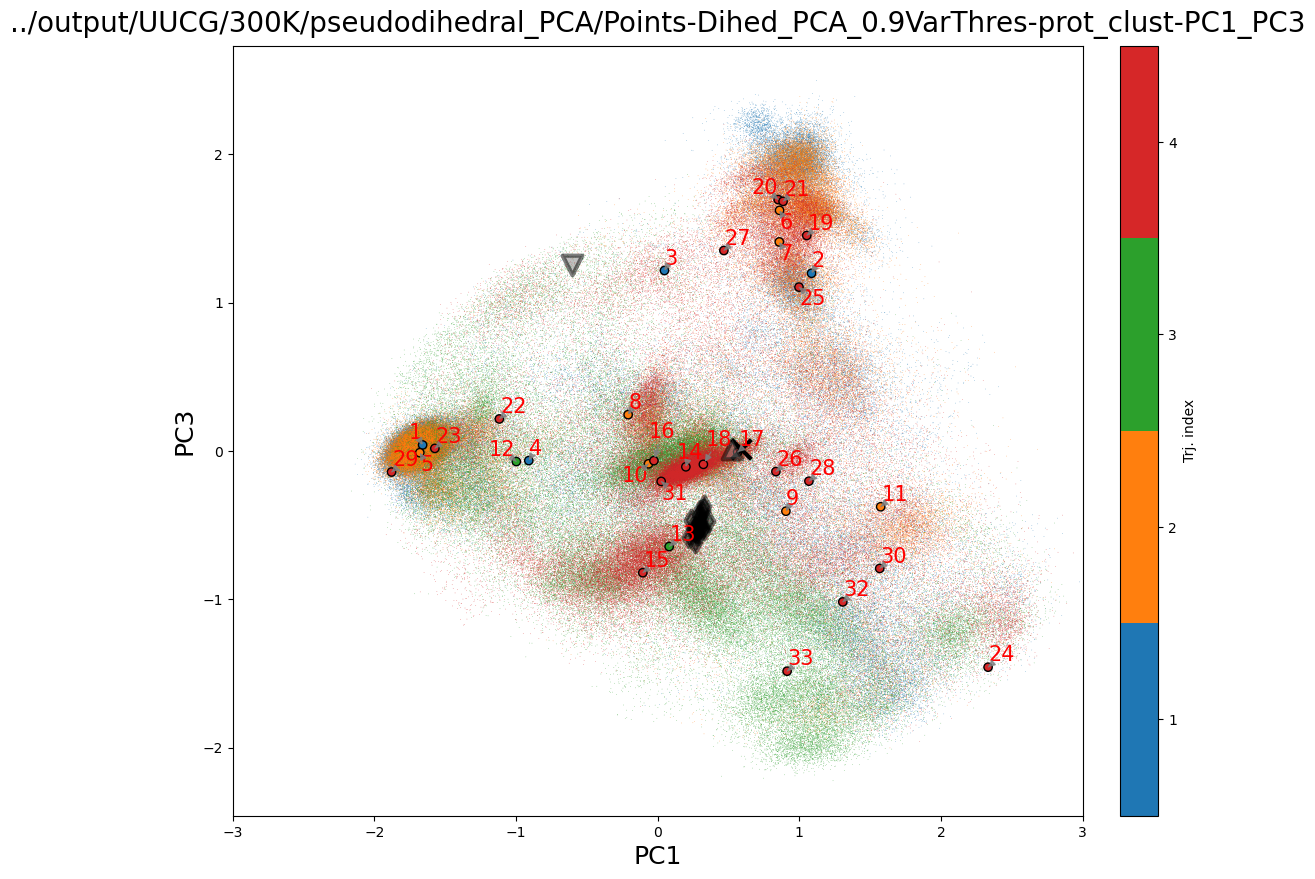

In [24]:
# do the same for PCs 1-3
plot_FES_and_dash_clusts(dih_pca_traj, cluster_pca , [0,2], 2*len(single_trj),\
                         "PC1", "PC3", "%s/Points-Dihed_PCA_0.9VarThres-prot_clust-PC1_PC3"%outdir) # plot FES and dash clusters

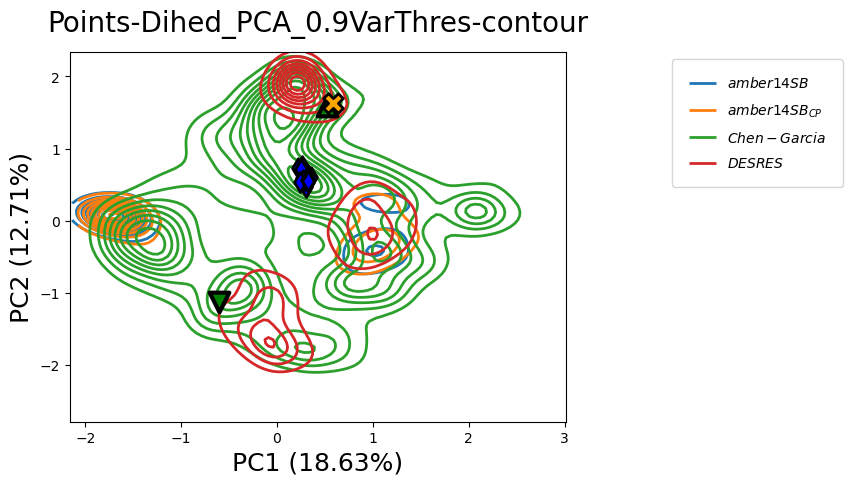

In [25]:
# Draw contour plots on the PC space.

fr_per_trj=2*len(single_trj)
dims = [0, 1]

def density_estimation(m1, m2):
    xmin = np.min(m1)
    xmax = np.max(m1)
    ymin = np.min(m2)
    ymax = np.max(m2)

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z , xmin, xmax, ymin, ymax


#Use the example you found.
fig, ax = plt.subplots()                   
# Show density 
x = dih_pca_traj[:, dims[0]]
y = dih_pca_traj[:, dims[1]]

# ax.scatter(x, y, color='grey', alpha=0.1, s=0.1) 
ax.set_xlim([np.min(x), np.max(x)])                                                                           
ax.set_ylim([np.min(y), np.max(y)])                                                                           

# Add contour lines
cat_cmap = categorical_cmap(len(ffs), 1, "tab10")

legend_handles = [] #list to save legend handles

for i, run in enumerate(runs):

    x = dih_pca_traj[i*fr_per_trj:(i+1)*fr_per_trj, dims[0]]
    y = dih_pca_traj[i*fr_per_trj:(i+1)*fr_per_trj, dims[1]]

    X, Y, Z, xmin, xmax, ymin, ymax = density_estimation(x, y)

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())

    CS = plt.contour(X, Y, Z, 10, colors=cat_cmap([i]), extend=max, linewidths=2)          

    CS.collections[i].set_label("$%s$"%(ffs[i]))
    
    #save legend hadles
    h,_ = CS.legend_elements()
    legend_handles.append(h)


# plt.scatter(dih_cos_traj[0,0], dih_cos_traj[0,1], marker='x', lw=3, s=100, c='orange', zorder=2)
plt.scatter(native_coords[:,0], native_coords[:,1], marker='X', lw=2, s=200, c='orange', ec="black", label="Reference", zorder=3)
plt.scatter(seed1_coords[:,dims[0]], seed1_coords[:,dims[1]], marker='^', lw=3, s=200, c='green', ec='black', zorder=2, label="NMR-seeded")
plt.scatter(seed2_coords[:,dims[0]], seed2_coords[:,dims[1]], marker='v', lw=3, s=200, c='green', ec='black', zorder=2, label="SimRNA-seeded")
plt.scatter(nmr_coords[:,dims[0]], nmr_coords[:,dims[1]], marker='d', lw=2, s=100, c='blue', ec="black", label="NMR", zorder=2)

# plt.legend(loc='upper left', bbox_to_anchor=(1.2,1), labelspacing=0.8, borderpad=1.2)
plt.legend([H[0] for H in legend_handles], ["$%s$"%ff for ff in ffs], loc='upper left', bbox_to_anchor=(1.2,1), labelspacing=0.8, borderpad=1.2, ncol=1)
plt.xlabel("PC%s (%.2f%s)"%(dims[0]+1, 100*dih_pca.cumvar[0], "%"),fontsize=18)
plt.ylabel("PC%s (%.2f%s)"%(dims[1]+1, 100*(dih_pca.cumvar[1]-dih_pca.cumvar[0]), "%"),fontsize=18)
plt.title("Points-Dihed_PCA_0.9VarThres-contour", fontsize=20, pad=15)
plt.savefig("%s/Points-Dihed_PCA_0.9VarThres-contour-PC1_PC2"%outdir + ".png", dpi = 600, format = "png", bbox_inches='tight')

plt.show()

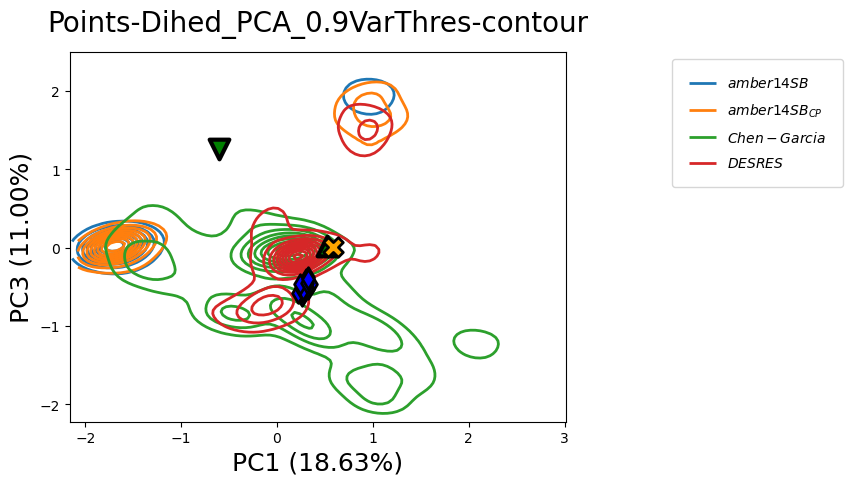

In [26]:
#do the same for PCs 1-3.

dims = [0, 2]

fig, ax = plt.subplots()                   
# Show density 
x = dih_pca_traj[:, dims[0]]
y = dih_pca_traj[:, dims[1]]

ax.set_xlim([np.min(x), np.max(x)])                                                                           
ax.set_ylim([np.min(y), np.max(y)])                                                                           

# Add contour lines
legend_handles = [] #list to save legend handles

for i, run in enumerate(runs):
    x = dih_pca_traj[i*fr_per_trj:(i+1)*fr_per_trj, dims[0]]
    y = dih_pca_traj[i*fr_per_trj:(i+1)*fr_per_trj, dims[1]]

    X, Y, Z, xmin, xmax, ymin, ymax = density_estimation(x, y)

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())

    CS = plt.contour(X, Y, Z, 10, colors=cat_cmap([i]), extend=max, linewidths=2)          
#     plt.clabel(CS, levels=CS.levels[::2], inline=1, fontsize=10)
    CS.collections[i].set_label("$%s$"%(ffs[i]))

    #save legend hadles
    h,_ = CS.legend_elements()
    legend_handles.append(h)


plt.scatter(native_coords[:,0], native_coords[:,2], marker='X', lw=2, s=200, c='orange', ec="black", label="Reference", zorder=3)
plt.scatter(seed1_coords[:,dims[0]], seed1_coords[:,dims[1]], marker='^', lw=3, s=200, c='green', ec='black', zorder=2, label="NMR-seeded")
plt.scatter(seed2_coords[:,dims[0]], seed2_coords[:,dims[1]], marker='v', lw=3, s=200, c='green', ec='black', zorder=2, label="SimRNA-seeded")
plt.scatter(nmr_coords[:,dims[0]], nmr_coords[:,dims[1]], marker='d', lw=2, s=100, c='blue', ec="black", label="NMR", zorder=2)

# plt.legend(loc='upper left', bbox_to_anchor=(1.2,1), labelspacing=0.8, borderpad=1.2)
plt.legend([H[0] for H in legend_handles], ["$%s$"%ff for ff in ffs], loc='upper left', bbox_to_anchor=(1.2,1), labelspacing=0.8, borderpad=1.2, ncol=1)
plt.xlabel("PC%s (%.2f%s)"%(dims[0]+1, 100*dih_pca.cumvar[0], "%"),fontsize=18)
plt.ylabel("PC%s (%.2f%s)"%(dims[1]+1, 100*(dih_pca.cumvar[2]-dih_pca.cumvar[1]), "%"),fontsize=18)
plt.title("Points-Dihed_PCA_0.9VarThres-contour", fontsize=20, pad=15)
plt.savefig("%s/Points-Dihed_PCA_0.9VarThres-contour-PC1_PC3"%outdir + ".png", dpi = 600, format = "png", bbox_inches='tight')

plt.show()
# plt.close()

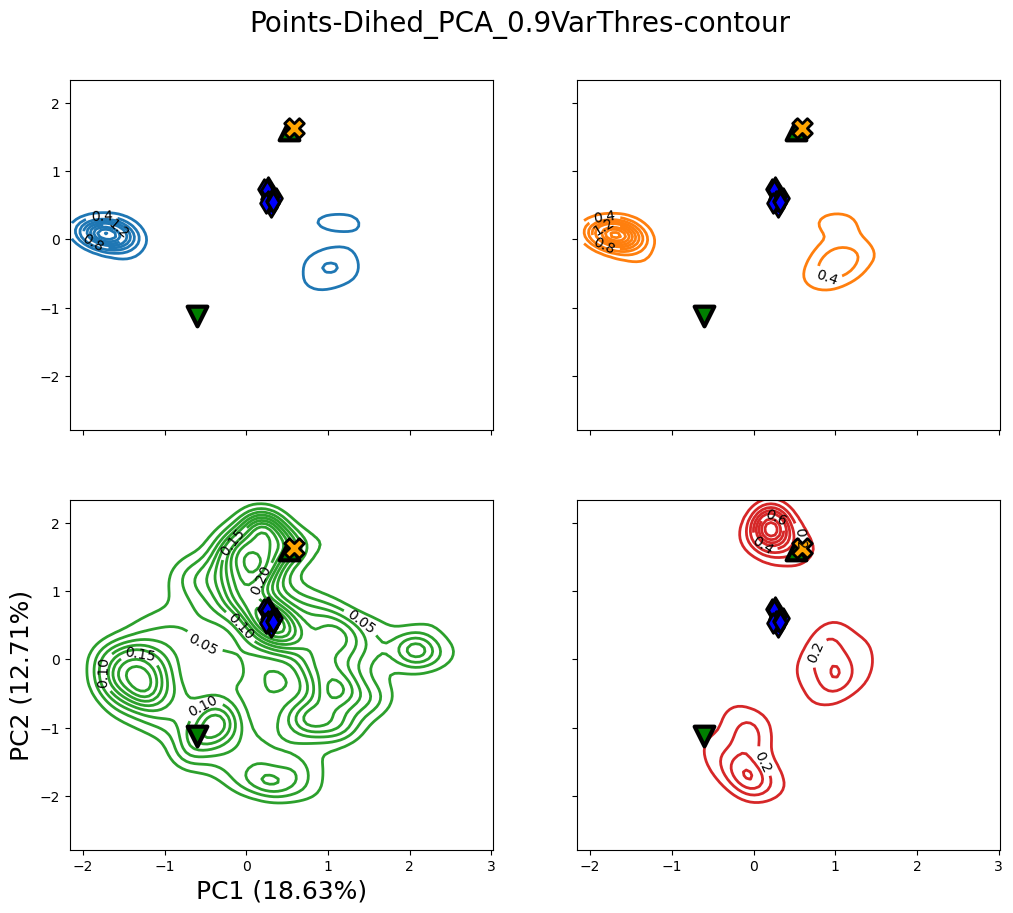

In [27]:
#Make individual contour plots on PC1-PC2 space.
dims = [0, 1]
rows=2
cols=2

#Plot the contours.
fig, ax = plt.subplots(nrows=rows,ncols=cols, sharex=True, sharey=True, squeeze=True, figsize=(12, 10))


# Add contour lines
for i, run in enumerate(runs):
    plt.subplot(rows, cols, i+1)

    # ax.scatter(x, y, color='grey', alpha=0.1, s=0.1) 
    plt.xlim([dih_pca_traj[:, dims[0]].min(), dih_pca_traj[:, dims[0]].max()])                                                                           
    plt.ylim([dih_pca_traj[:, dims[1]].min(), dih_pca_traj[:, dims[1]].max()])                                                                           
        

    x = dih_pca_traj[i*fr_per_trj:(i+1)*fr_per_trj, dims[0]]
    y = dih_pca_traj[i*fr_per_trj:(i+1)*fr_per_trj, dims[1]]

    X, Y, Z, xmin, xmax, ymin, ymax = density_estimation(x, y)

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())

    CS = plt.contour(X, Y, Z, 10, colors=cat_cmap([i]), extend=max, linewidths=2) 
    plt.clabel(CS, levels=CS.levels[::2], inline=1, fontsize=10, colors="k")
    CS.collections[counter].set_label("$%s$"%(ffs[i]))
        

    plt.scatter(native_coords[:,0], native_coords[:,1], marker='X', lw=2, s=200, c='orange', ec="black", label="Reference", zorder=3)
    plt.scatter(seed1_coords[:,dims[0]], seed1_coords[:,dims[1]], marker='^', lw=3, s=200, c='green', ec='black', zorder=2, label="NMR-seeded")
    plt.scatter(seed2_coords[:,dims[0]], seed2_coords[:,dims[1]], marker='v', lw=3, s=200, c='green', ec='black', zorder=2, label="SimRNA-seeded")
    plt.scatter(nmr_coords[:,dims[0]], nmr_coords[:,dims[1]], marker='d', lw=2, s=100, c='blue', ec="black", label="NMR", zorder=2)

# plt.legend(loc='upper left', bbox_to_anchor=(1.2,1), labelspacing=0.8, borderpad=1.2)
ax[1,0].set_xlabel("PC%s (%.2f%s)"%(dims[0]+1, 100*dih_pca.cumvar[0], "%"),fontsize=18)
ax[1,0].set_ylabel("PC%s (%.2f%s)"%(dims[1]+1, 100*(dih_pca.cumvar[1]-dih_pca.cumvar[0]), "%"),fontsize=18)
plt.suptitle("Points-Dihed_PCA_0.9VarThres-contour", fontsize=20, y=0.95)
plt.savefig("%s/Points-Dihed_PCA_0.9VarThres-panels-PC1_PC2"%outdir + ".png", dpi = 600, format = "png", bbox_inches='tight')

plt.show()

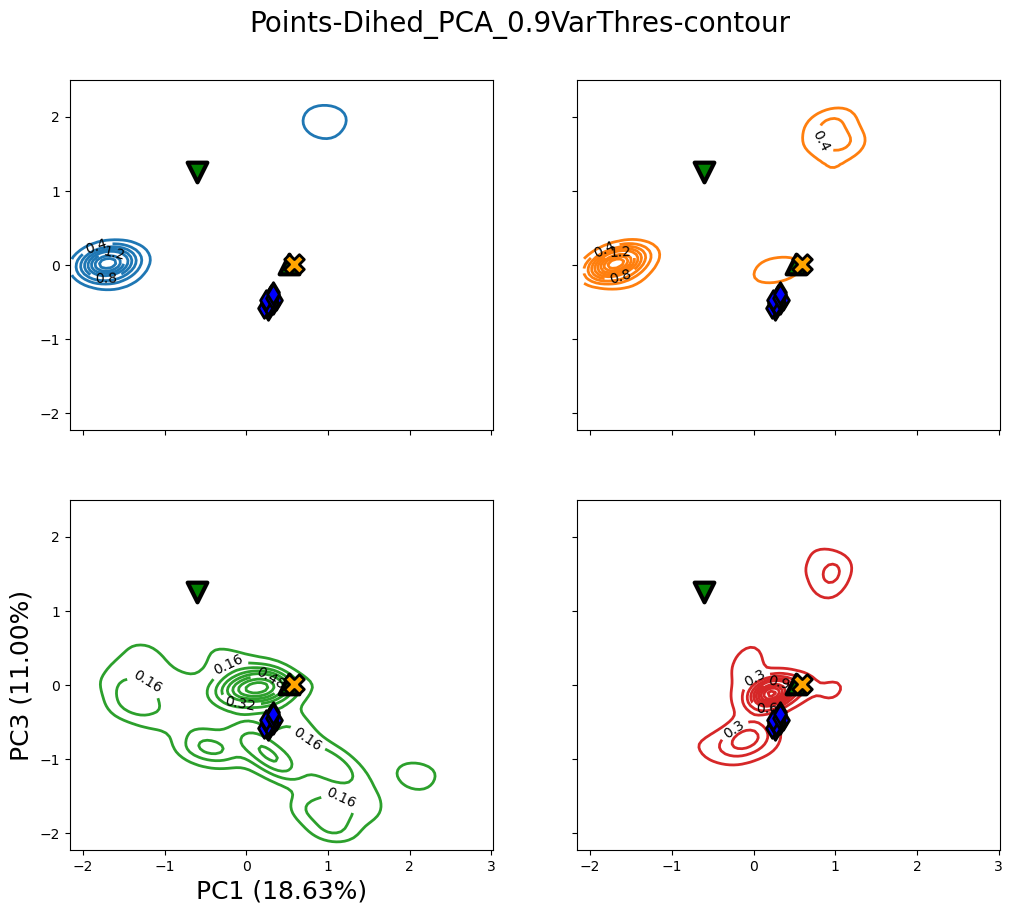

In [28]:
#Make individual contour plots on PC1-PC3 space.
dims = [0, 2]

#Plot the contours.
fig, ax = plt.subplots(nrows=rows,ncols=cols, sharex=True, sharey=True, squeeze=True, figsize=(12, 10))


# Add contour lines
for i, run in enumerate(runs):
    plt.subplot(rows, cols, i+1)

    # ax.scatter(x, y, color='grey', alpha=0.1, s=0.1) 
    plt.xlim([dih_pca_traj[:, dims[0]].min(), dih_pca_traj[:, dims[0]].max()])                                                                           
    plt.ylim([dih_pca_traj[:, dims[1]].min(), dih_pca_traj[:, dims[1]].max()])                                                                           
        
    x = dih_pca_traj[i*fr_per_trj:(i+1)*fr_per_trj, dims[0]]
    y = dih_pca_traj[i*fr_per_trj:(i+1)*fr_per_trj, dims[1]]

    X, Y, Z, xmin, xmax, ymin, ymax = density_estimation(x, y)

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())

    CS = plt.contour(X, Y, Z, 10, colors=cat_cmap([i]), extend=max, linewidths=2)  
    plt.clabel(CS, levels=CS.levels[::2], inline=1, fontsize=10, colors="k")
    CS.collections[i].set_label("$%s$"%(ffs[i]))

    plt.scatter(native_coords[:,dims[0]], native_coords[:,dims[1]], marker='X', lw=2, s=200, c='orange', ec="black", label="Reference", zorder=3)
    plt.scatter(seed1_coords[:,dims[0]], seed1_coords[:,dims[1]], marker='^', lw=3, s=200, c='green', ec='black', zorder=2, label="NMR-seeded")
    plt.scatter(seed2_coords[:,dims[0]], seed2_coords[:,dims[1]], marker='v', lw=3, s=200, c='green', ec='black', zorder=2, label="SimRNA-seeded")
    plt.scatter(nmr_coords[:,dims[0]], nmr_coords[:,dims[1]], marker='d', lw=2, s=100, c='blue', ec="black", label="NMR", zorder=2)

# plt.legend(loc='upper left', bbox_to_anchor=(1.2,1), labelspacing=0.8, borderpad=1.2)
ax[1,0].set_xlabel("PC%s (%.2f%s)"%(dims[0]+1, 100*dih_pca.cumvar[0], "%"),fontsize=18)
ax[1,0].set_ylabel("PC%s (%.2f%s)"%(dims[1]+1, 100*(dih_pca.cumvar[2]-dih_pca.cumvar[1]), "%"),fontsize=18)
plt.suptitle("Points-Dihed_PCA_0.9VarThres-contour", fontsize=20, y=0.95)
plt.savefig("%s/Points-Dihed_PCA_0.9VarThres-panels-PC1_PC3"%outdir + ".png", dpi = 600, format = "png", bbox_inches='tight')

plt.show()